In [2]:
# Import useful libraries
import os
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
# import seaborn as sns
# sns.set_style("whitegrid") # better looking plots
print("Using GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

Using GPU: True


/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845206/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
# plotting utilities

def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

def plot_field(domain,model,output_func=None,V_exact=None,plot_diff=False,n_points=10000,fields_name=None):

    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))

    plotify = lambda x: x.reshape(Xgrid.shape)

    if output_func is None:
        V_nn = model.predict(Xinput)
    else:
        V_nn = model.predict(Xinput, operator=output_func)

    V_nn = [plotify(V) for V in V_nn]

    n_fields = len(V_nn) if type(V_nn) is list else 1
    n_plot = 1

    if fields_name is None:
        fields_name = V_exact.__name__.replace('_exact','') if V_exact is not None else 'V'

    coord = ["_x","_y","_xy"] if n_fields > 1 else [""]
    fields_name = [fields_name + coord[i] for i in range(n_fields)]

    if V_exact is not None:
        V_exact = V_exact(Xinput)
        V_exact = [plotify(V) for V in V_exact]
        n_plot = 3 if plot_diff else 2
        
    fig, ax = plt.subplots(n_fields, n_plot, figsize=(4*n_plot, 3*n_fields), dpi=200)

    for i in range(n_fields):
        subax = ax if n_fields == 1 else ax[i] 

        if V_exact is not None:

            cmax = max(V_nn[i].max(), V_exact[i].max())
            cmin = min(V_nn[i].min(), V_exact[i].min())

            im1 = pcolor_plot(subax[0], Xgrid, Ygrid, V_exact[i], f"{fields_name[i]}*", cmin=cmin, cmax=cmax)
            im2 = pcolor_plot(subax[1], Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn", cmin=cmin, cmax=cmax)

            fig.colorbar(im1, ax=subax[1])
        else:
            im1 = pcolor_plot(subax, Xgrid, Ygrid, V_nn[i], f"{fields_name[i]}_nn")
            fig.colorbar(im1, ax=subax)

        if plot_diff:
            diff = V_nn[i] - V_exact[i]
            abs_diff = np.abs(diff)
            cmax = abs_diff.max() if diff.max() > 0 else 0
            cmin = -abs_diff.max() if diff.min() < 0 else 0
            im3 = pcolor_plot(subax[2], Xgrid, Ygrid,diff, f"{fields_name[i]}_nn - {fields_name[i]}*", cmin=cmin, cmax=cmax, colormap="coolwarm")
            fig.colorbar(im3, ax=subax[2])
            subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")

    return fig

<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_28558/882093937.py:71: SyntaxWarning: invalid escape sequence '\m'
  subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")
/tmp/ipykernel_28558/882093937.py:71: SyntaxWarning: invalid escape sequence '\m'
  subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")


In [4]:
lmbd = 1.0
mu = 0.5
Q = 4.0

def U_exact(X):
    x, y = X[:,0], X[:,1]
    #displacement U
    Ux = np.cos(2*np.pi*x) * np.sin(np.pi*y)
    Uy = np.sin(np.pi*x) * Q * y**4/4
    return np.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1)))

def E_exact(X):
    #strain E
    x, y = X[:,0], X[:,1]
    Exx = -2*np.pi*np.sin(2*np.pi*x)*np.sin(np.pi*y)
    Eyy = np.sin(np.pi*x)*Q*y**3
    Exy = 0.5*(np.pi*np.cos(2*np.pi*x)*np.cos(np.pi*y) + np.pi*np.cos(np.pi*x)*Q*y**4/4)
    return (Exx, Eyy, Exy)

def S_exact(X):
    #stress S
    Sxx = (lmbd + 2*mu) * E_exact(X)[0] + lmbd * E_exact(X)[1]
    Syy = (lmbd + 2*mu) * E_exact(X)[1] + lmbd * E_exact(X)[0]
    Sxy = 2*mu*E_exact(X)[2]
    return (Sxx, Syy, Sxy)

def bodyf_exact(X):
    #body force
    x, y = X[:,0], X[:,1]
    fx = lmbd*(4*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y)-np.pi*np.cos(np.pi*x)*Q*y**3) \
        + mu*(9*np.pi**2*np.cos(2*np.pi*x)*np.sin(np.pi*y) - np.pi*np.cos(np.pi*x)*Q*y**3)
    fy = lmbd*(-3*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y)) \
        + mu*(-6*np.sin(np.pi*x)*Q*y**2 + 2*np.pi**2*np.sin(2*np.pi*x)*np.cos(np.pi*y) + (np.pi**2*np.sin(np.pi*x)*Q*y**4)/4)
    return (fx, fy)
    
def E_potential_exact(X):
    #potential energy
    E_strain = 1/2 * (E_exact(X)[0]*S_exact(X)[0] + E_exact(X)[1]*S_exact(X)[1] + 2*E_exact(X)[2]*S_exact(X)[2])
    W_bodyf = U_exact(X)[:,0]*bodyf_exact(X)[0] + U_exact(X)[:,1]*bodyf_exact(X)[1]
    E_potential = E_strain - W_bodyf 
    return [E_potential]

In [5]:
# physical functions for tensors (output of the network) using deepxde differential operators
def bodyf(X, mu, lmbd):
    #body force
    x, y = X[:,0:1], X[:,1:2]
    fx = lmbd*(4*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y)-torch.pi*torch.cos(torch.pi*x)*Q*y**3) \
        + mu*(9*torch.pi**2*torch.cos(2*torch.pi*x)*torch.sin(torch.pi*y) - torch.pi*torch.cos(torch.pi*x)*Q*y**3)
    fy = lmbd*(-3*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y)) \
        + mu*(-6*torch.sin(torch.pi*x)*Q*y**2 + 2*torch.pi**2*torch.sin(2*torch.pi*x)*torch.cos(torch.pi*y) + (torch.pi**2*torch.sin(torch.pi*x)*Q*y**4)/4)
    return (fx, fy)

def E_nn(X,U):
    #calculate the strain given the displacement
    # u is the output of the NN, a tensor of shape (N,2)
    Exx = dde.grad.jacobian(U, X, i=0, j=0)
    Eyy = dde.grad.jacobian(U, X, i=1, j=1)
    Exy = 0.5 * (dde.grad.jacobian(U, X, i=1, j=0) +dde.grad.jacobian(U, X, i=0, j=1))
    return Exx, Eyy, Exy

def S_nn(E,lmbd,mu):
    #calculate the stress given the strain
    Sxx = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy = 2 * mu * E[2]
    return Sxx, Syy, Sxy

def PDE(X,S):
    """
    the PDE of the problem (momentum balance)
    X is the spatial coordinate of shape (N,2) (x,y) 
    S is the stress tensor of shape (N,3) (Sxx, Syy, Sxy)
    """

    Sxx, Syy, Sxy = S
    S = torch.stack((Sxx.reshape(-1,1), Syy.reshape(-1,1), Sxy.reshape(-1,1)), axis=1)
        
    dSxx_x = dde.grad.jacobian(S, X, i=0, j=0)
    dSyy_y = dde.grad.jacobian(S, X, i=1, j=1)
    dSxy_x = dde.grad.jacobian(S, X, i=2, j=0)
    dSxy_y = dde.grad.jacobian(S, X, i=2, j=1)
    
    fx, fy = bodyf(X, mu, lmbd)
    momentum_x = dSxx_x + dSxy_y + fx
    momentum_y = dSyy_y + dSxy_x + fy
    return [momentum_x, momentum_y]

def E_potential(U,E,S,bodyf):
    """
    calculate the potential energy of the system
    U is the displacement tensor of shape (N,2) U[:,0] = Ux, U[:,1] = Uy
    E is the strain of list of length 3 (Exx, Eyy, Exy)
    S is the stress of list of length 3 (Sxx, Syy, Sxy)
    bodyf is the body force of list of length 2 (fx, fy)
    """
    strain_energy = 0.5 * (S[0]*E[0] + S[1]*E[1] + 2*S[2]*E[2])
    bodyf_work = U[:,0:1] * bodyf[0] + U[:,1:2] * bodyf[1]
    E_pot = strain_energy - bodyf_work
    return [E_pot]

def Material_error(E,S,lmbd,mu):
    """
    calculate the material behavior error
    E is the strain of list of length 3 (Exx, Eyy, Exy)
    S is the stress of list of length 3 (Sxx, Syy, Sxy)
    lmbd and mu are the material properties for linear elasticity
    """
    Sxx, Syy, Sxy = S
    
    Sxx_pred = (2 * mu + lmbd) * E[0] + lmbd * E[1]
    Syy_pred = (2 * mu + lmbd) * E[1] + lmbd * E[0] 
    Sxy_pred = 2 * mu * E[2]

    Material_error = torch.square(Sxx - Sxx_pred) + torch.square(Syy - Syy_pred) + torch.square(Sxy - Sxy_pred)
    return Material_error

 ## Architecture for inverse identification of $\lambda$ and $\mu$

In [6]:
lmbd_dde = dde.Variable(1.0)
mu_dde = dde.Variable(1.0)

def PDE_net(x,net_output):
    """"
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,5), the displacement u_x, u_y, the stress S_xx, S_yy, S_xy, only the stress is used in the PDE
    return: the PDE of the problem
    """
    S = net_output[:,2], net_output[:,3], net_output[:,4]
    pde = PDE(x,S)
    return pde

def Epot_net(x,net_output):
    """
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,5), the displacement u_x, u_y, the stress S_xx, S_yy, S_xy, only the stress is used in the potential energy
    return: the potential energy of the system
    """
    U = torch.hstack((net_output[:,0].reshape(-1,1),net_output[:,1].reshape(-1,1)))
    E = E_nn(x,U)
    S = S_nn(E,lmbd_dde,mu_dde)
    bodyf_val = bodyf(x, mu, lmbd)
    E_pot = E_potential(U,E,S,bodyf_val)
    return E_pot

def MaterialError_net(x,net_output):
    """
    x: input tensor of shape (N,2), the spatial coordinates x and y
    net_output: output tensor of shape (N,5), the displacement u_x, u_y, the stress S_xx, S_yy, S_xy
    return: the material behavior error: the squared difference between the stress predicted by the network and the stress predicted by the linear elasticity from the displacement 
    """
    U = torch.hstack((net_output[:,0].reshape(-1,1),net_output[:,1].reshape(-1,1)))
    E = E_nn(x,U)
    S = net_output[:,2].reshape(-1,1), net_output[:,3].reshape(-1,1), net_output[:,4].reshape(-1,1)
    return [Material_error(E,S,lmbd_dde,mu_dde)]

total_loss = lambda x,net_output: PDE_net(x,net_output) + MaterialError_net(x,net_output)

def Enforce_BC(x,net_output):
    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]

    Sxx = net_output[:,2]*x[:,0]*(1-x[:,0])
    Syy = net_output[:,3]*(1-x[:,1]) + (lmbd + 2*mu)*Q*torch.sin(torch.pi*x[:,0])
    Sxy = net_output[:,4] 
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1),Sxx.reshape(-1,1),Syy.reshape(-1,1),Sxy.reshape(-1,1))) 

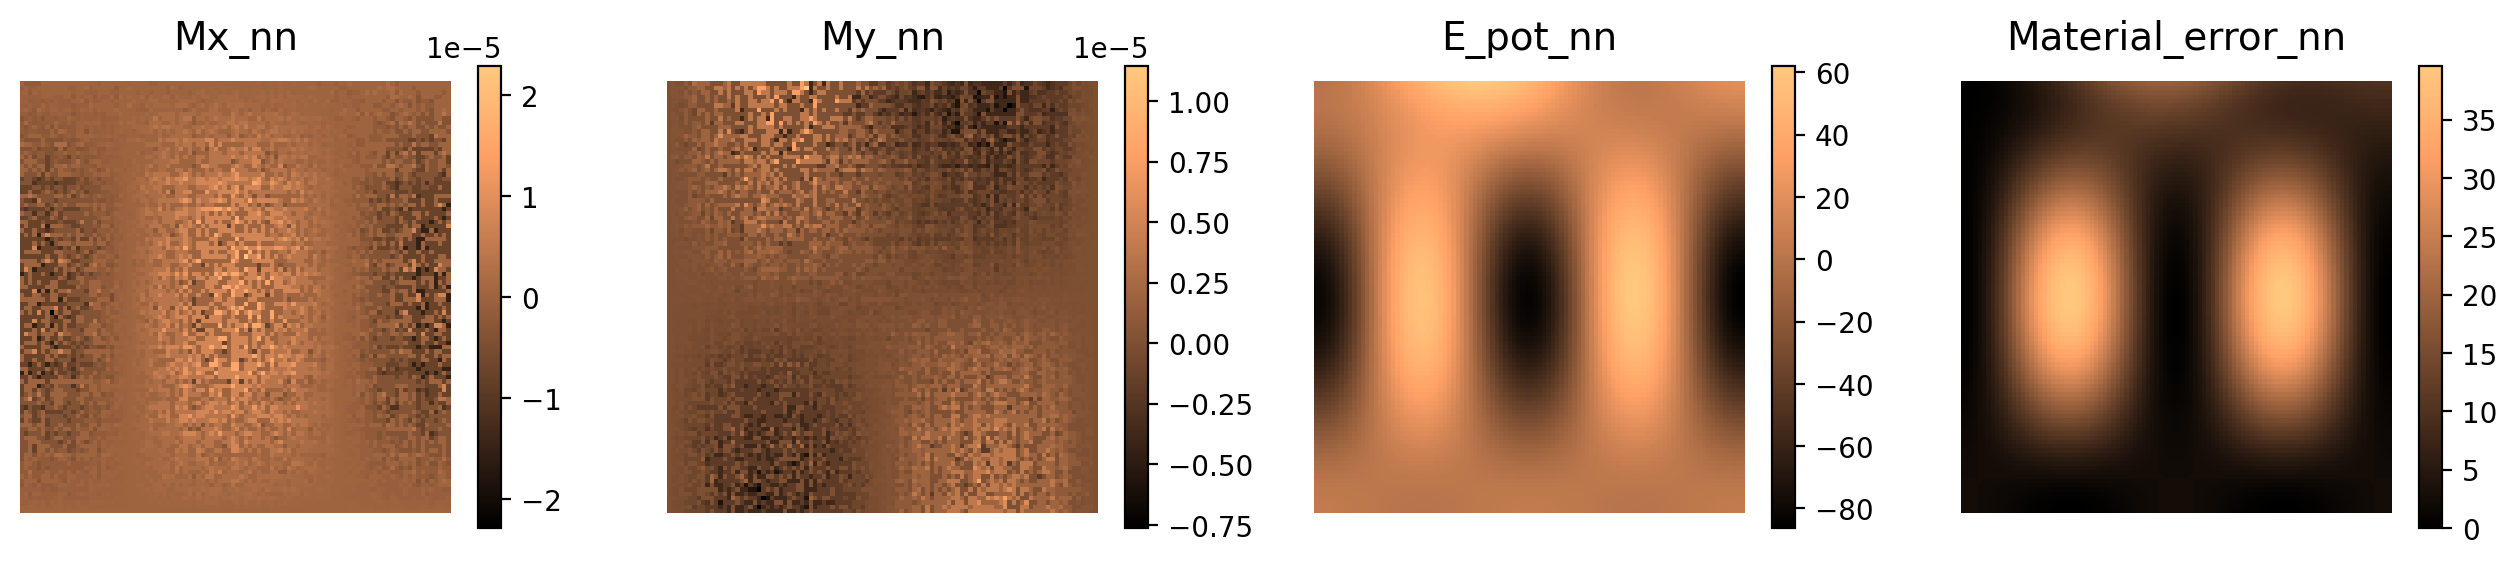

In [7]:
#check the loss function
domain = [[0,1],[0,1]]

X = np.linspace(domain[0][0], domain[0][1], 100)
Y = np.linspace(domain[1][0], domain[1][1], 100)
Xgrid, Ygrid = np.meshgrid(X, Y)
Xinput = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
Xtorch = torch.from_numpy(Xinput).float().to(device)
Xtorch.requires_grad = True

def NN_exact(x,lib='np'):
    # ground truth output of the network
    if lib == 'torch':
        cos,sin,pi,hstack = torch.cos,torch.sin,torch.pi,torch.hstack
    elif lib == 'np':
        cos,sin,pi,hstack = np.cos,np.sin,np.pi,np.hstack

    Ux = cos(2*pi*x[:,0]) * sin(pi*x[:,1])
    Uy = sin(pi*x[:,0]) * Q * x[:,1]**4/4

    Exx = -2*pi*sin(2*pi*x[:,0])*sin(pi*x[:,1])
    Eyy = sin(pi*x[:,0])*Q*x[:,1]**3
    Exy = 0.5*(pi*cos(2*pi*x[:,0])*cos(pi*x[:,1]) + pi*cos(pi*x[:,0])*Q*x[:,1]**4/4)

    S = S_nn((Exx,Eyy,Exy),lmbd,mu)
    Sxx, Syy, Sxy = S[0], S[1], S[2]

    return hstack((Ux.reshape(-1,1),Uy.reshape(-1,1),Sxx.reshape(-1,1),Syy.reshape(-1,1),Sxy.reshape(-1,1))) 


PDE_test = PDE_net(Xtorch,NN_exact(Xtorch,'torch'))
E_pot_test = Epot_net(Xtorch,NN_exact(Xtorch,'torch'))

fig, ax = plt.subplots(1,4, figsize=(16, 3), dpi=200)
im = pcolor_plot(ax[0], Xgrid, Ygrid, PDE_test[0].detach().cpu().reshape(Xgrid.shape), "Mx_nn")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], Xgrid, Ygrid, PDE_test[1].detach().cpu().reshape(Xgrid.shape), "My_nn")
fig.colorbar(im, ax=ax[1])
im = pcolor_plot(ax[2], Xgrid, Ygrid, E_pot_test[0].detach().cpu().reshape(Xgrid.shape), "E_pot_nn")
fig.colorbar(im, ax=ax[2])
im = pcolor_plot(ax[3], Xgrid, Ygrid, MaterialError_net(Xtorch,NN_exact(Xtorch,'torch'))[0].detach().cpu().reshape(Xgrid.shape), "Material_error_nn")
fig.colorbar(im, ax=ax[3])

In [8]:
def generate_measures(domain, num_points, func, noise=0.0, seed=None):
    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(num_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(num_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    X_obs = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
    Yexact = func(X_obs)
    Y_obs = Yexact + noise * np.random.randn(*Yexact.shape)
    return X_obs, Y_obs

# generate training data
X_obs, U_obs = generate_measures(domain, 400, U_exact, noise=0.0)

observe_Ux = dde.PointSetBC(X_obs, U_obs[:, 0:1], component=0)
observe_Uy = dde.PointSetBC(X_obs, U_obs[:, 1:2], component=1)

geom = dde.geometry.Rectangle([0, 0], [1, 1])
# material_behavior = dde.icbc.OperatorBC()
bc = [observe_Ux, observe_Uy]
num_domain = 300

data = dde.data.PDE(
    geom,
    total_loss,
    bc,
    num_domain=num_domain,
    num_test= num_domain,
    solution=NN_exact,
    anchors=X_obs,
)

# net = dde.nn.PFNN([2, [20]*5, [20]*5, [20]*5,[20]*5, 5], "tanh", "Glorot normal")
net = dde.nn.FNN([2, 50 ,50 ,50 ,50 , 5], "sigmoid", "Glorot normal")

net.apply_output_transform(Enforce_BC)

model = dde.Model(data, net)


# sanity check that BCs are enforced
U_output = lambda x, u: (u[:,0], u[:,1]) 
S_output = lambda x, u: (u[:,2], u[:,3], u[:,4])

# plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
# plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was infe

In [9]:
trainable_variables = [lmbd_dde, mu_dde]
variable = dde.callbacks.VariableValue(trainable_variables, period=100, filename="elasticity_param.dat")
checkpointer = dde.callbacks.ModelCheckpoint("dde_inverse/model_FNN", verbose=1, save_better_only=True)

model.compile("adam", lr=0.0001, external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=3000,display_every=1000, callbacks=[variable])#, checkpointer])

# # train lbfgs
model.compile("L-BFGS", external_trainable_variables=trainable_variables, metrics=["l2 relative error"])
losshistory, train_state = model.train(callbacks=[variable])
print(f"lambda:{lmbd_dde} ; mu: {mu_dde}")

Compiling model...
'compile' took 0.364311 s

Training model...



RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [20]:
print(f"lambda:{lmbd_dde} ; mu: {mu_dde}")

lambda:0.4194912612438202 ; mu: 1.3446521759033203


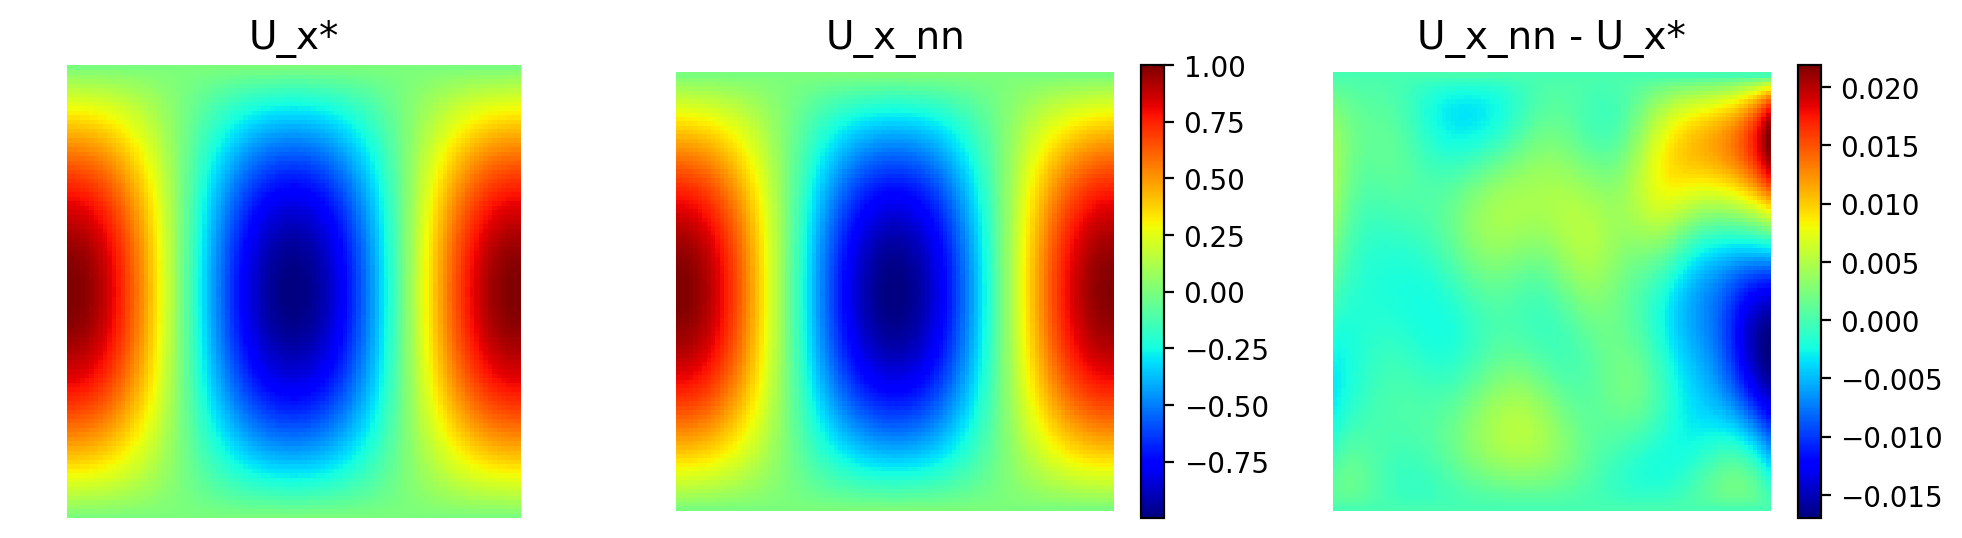

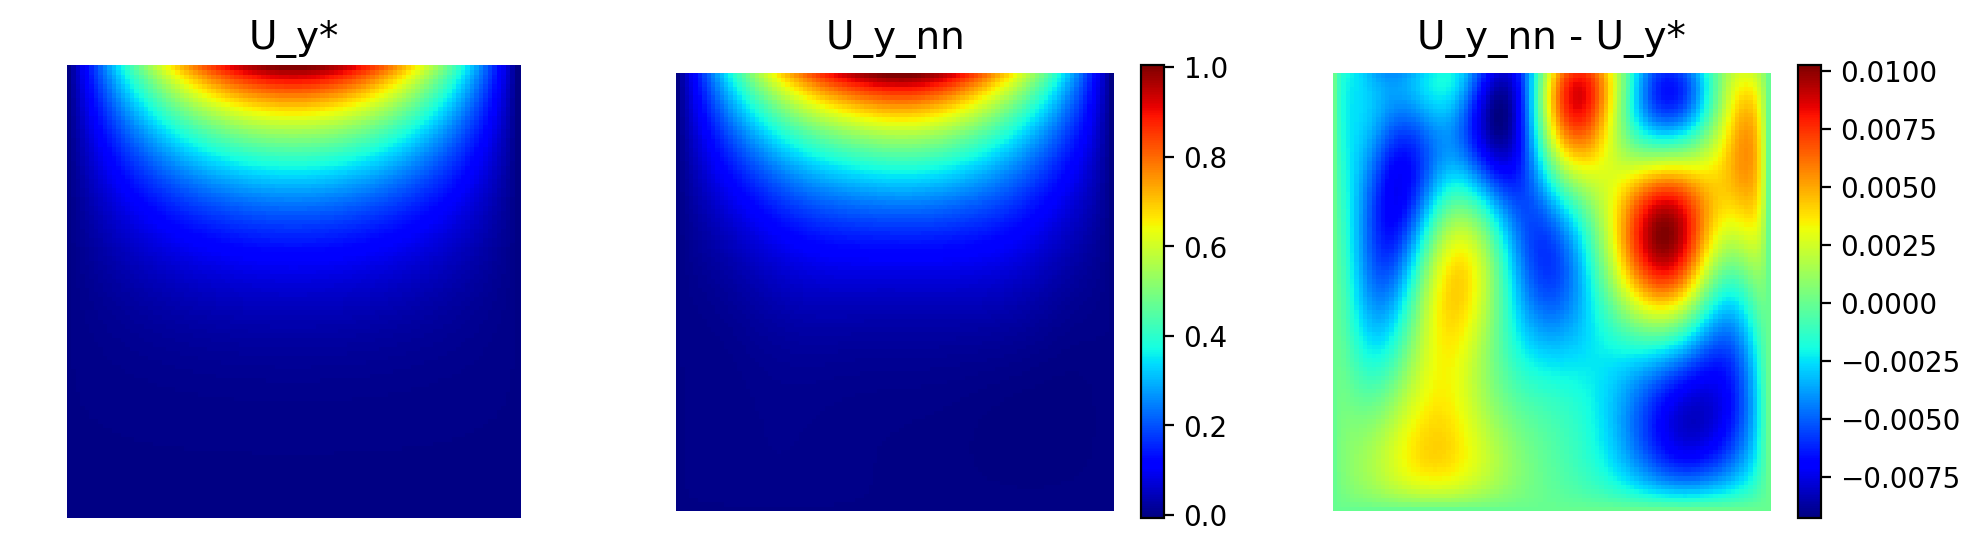

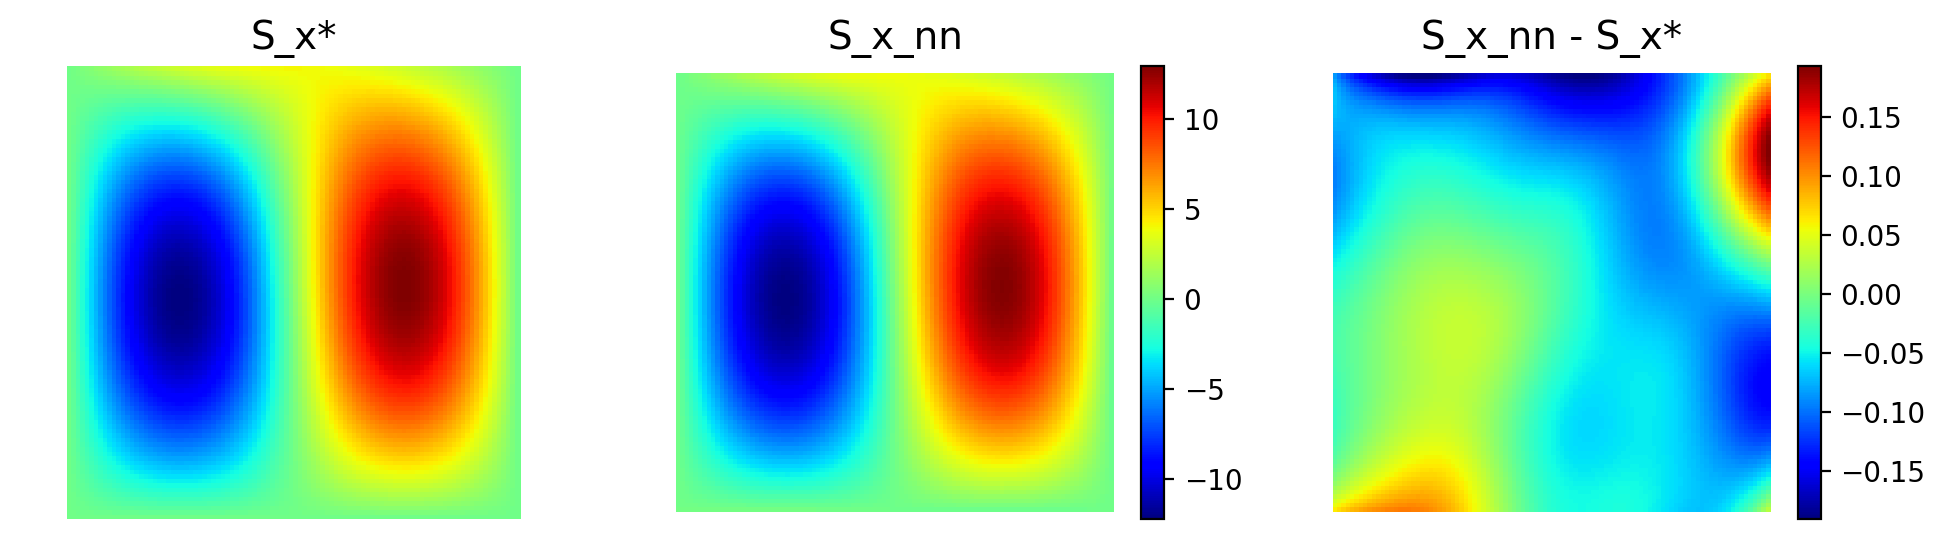

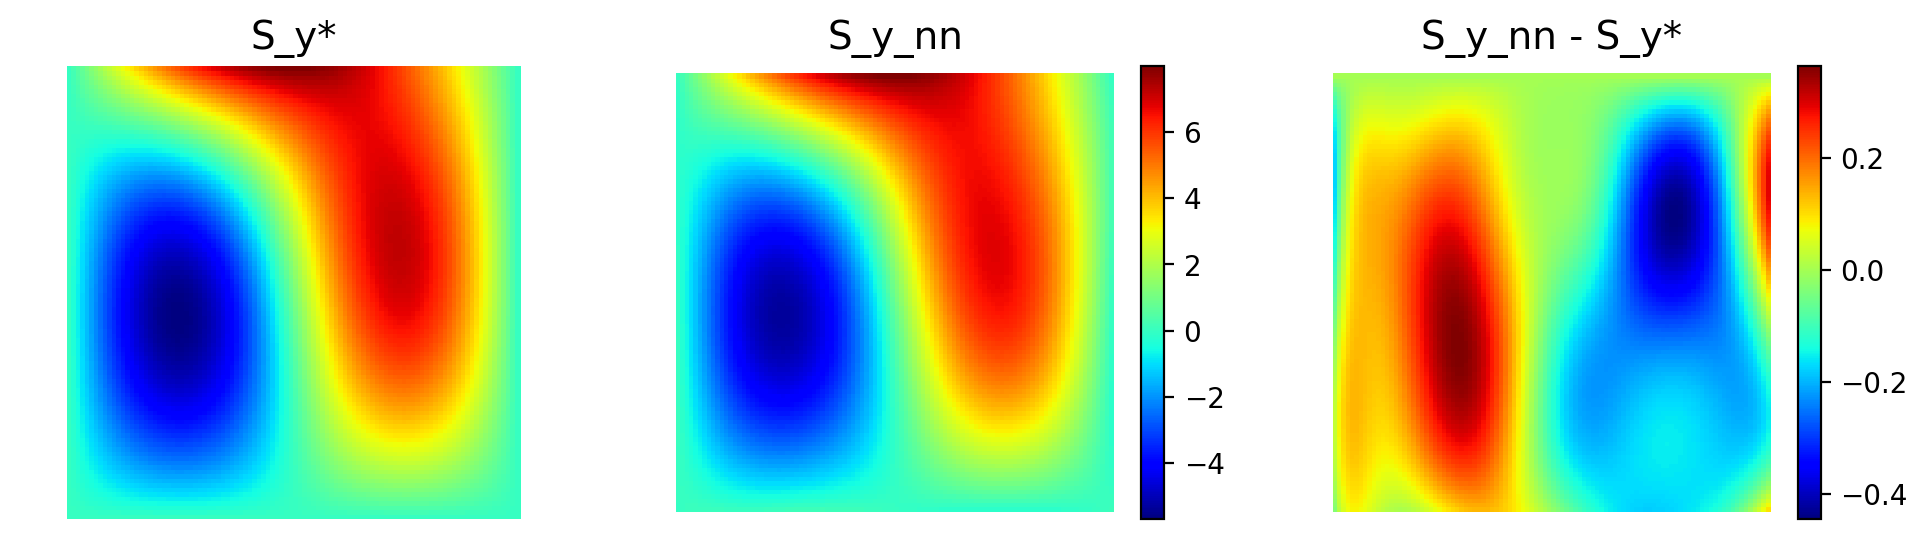

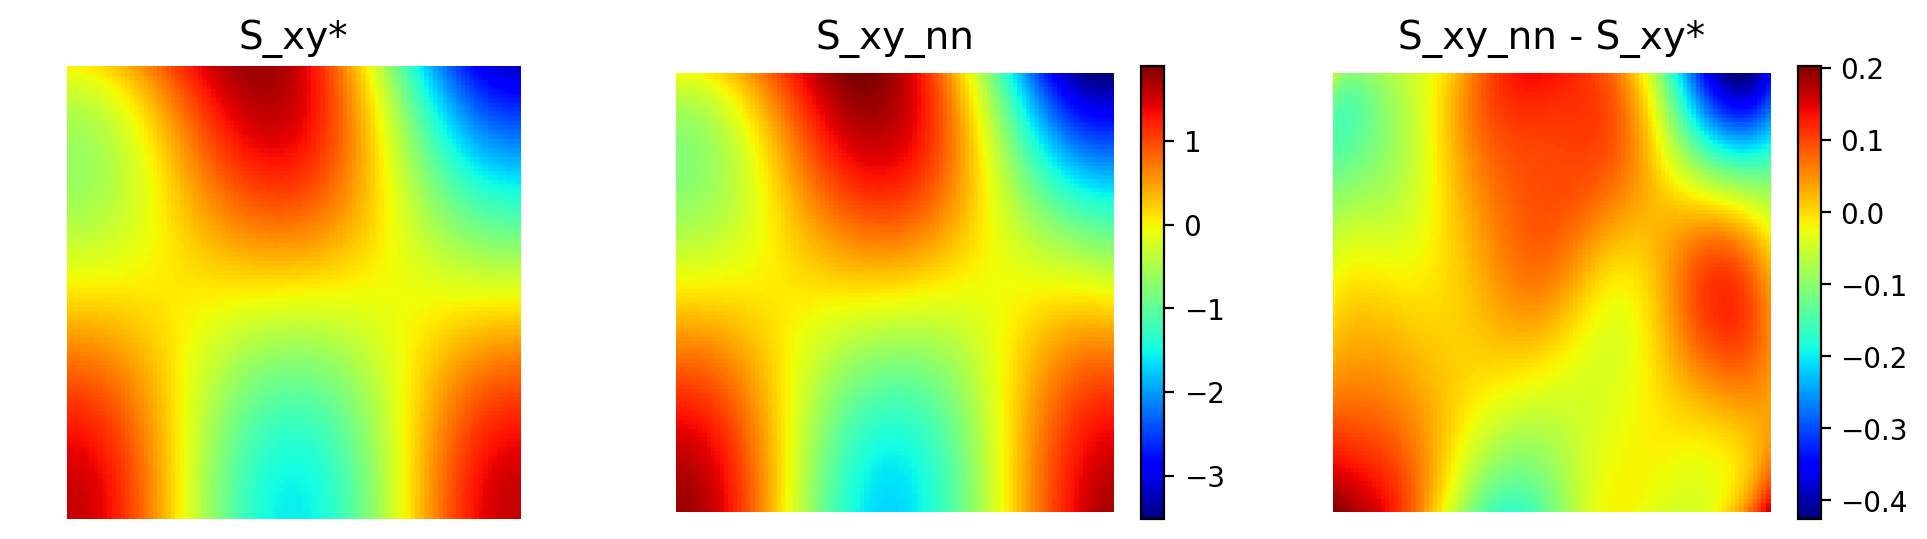

In [28]:
plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")